# How to detect and mitigate Bias in Machine Learning
For the Seminar "Statistical Machine Learning" at the Otto-Friedrich University of Bamberg Louisa Heidrich and Bianca Zimmer chose to investigate the topic Representativeness vs. Fairness. For the theoretical background please see our presentention.   
<br />
To demonstrate some of the fairness methods listed in our presentation we decided to use an open-source data set about American homicide data (https://www.kaggle.com/murderaccountability/homicide-reports). The data set contains information about location, time and victim of the crime. If the crime was solved we also have information about the perpetrator and their relationship to the victim.

### Table of Contents

* [0. Load packages and global variables](#chapter0)
* [1. Introduction](#chapter1)
* [2. AIF360 Tool](#chapter2)
* [3. Bias Detection](#chapter3)
* [4. Bias Mitigation](#chapter4)
* [5. Results of applying the AIF360 Tool](#chapter5)
* [6. Conclusion](#chapter6)
* [7. References](#chapter7)



# 0. Load packages and global variables <a class="anchor" id="chapter0"></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns
import plotly.offline as py

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import Markdown, display

In [ ]:
import sys
sys.version

'3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]'

# 1. Introduction <a class="anchor" id="chapter1"></a>

2016 Microsoft started a chatbot on Twitter named Tay. Tay was a machine learning experiment. She should learn how to communicate naturally with people through social media. However nobody was ready for what happened next: Tay turned into a racist in less than 24 hours.   
This incident started a debate about what machine learning algorithms have to do with fairness and who is responsible for the (un-)fairness of models. Bias per se has been in the discussion for a long time when speaking about models in general but fairness takes this whole concept a step into the ethical direction. A quote which describes this situation perfectly by Barocas et al. 2017 reads as follows:   

```
Our historical examples of the relevant outcomes will almost always reflect historical prejudices
against certain social groups, prevailing cultural stereotypes, and existing demographic inequalities.
And finding patterns in these data will often mean replicating these very same dynamics. (Barocas et al. 2017)
```
The first problem we come across is the question "How do we measure fairness?". This a very difficult and nearly philosophical question which is reflected by the fact that there are over 20 measurements for fairness.   
The next question is: "How can we mitigate that bias in fairness while still producing a valid model?". There have been approaches to mitigate bias mathematically in different stages of the model finding process all with a different focus.  
<br /> 
In the course of this project we will try to answer some of these questions by
* Introducing some fairness metrics
* Applying methods to mitigate bias before, during and after finding a model
* Testing the AIF360 toolkit by IBM on a real life dataset (Homicide Data)

<br /> 
It is important to notice that the aim of this project is not to find the best prediction model. However we will apply some baseline data quality review and clean up in order to get a fairly useful model. We decided on predicting whether a crime was solved or not depending on the remaining available variables in the homicide dataset.


### 1.1 Load and review dataset "U.S. Homicide Reports" (1980-2014)

First of all, let's have a look at the dataset. It consists of 638,454 observations on homicides in the U.S. between 1980 and 2014. For this purpose 24 attributes were collected and are listed below. 

In [ ]:
#load data set from github repository
url = 'https://github.com/BiancaZimmer/Stat-ML-Fairness/raw/2d723889786d615e656c87c479959ee143176c65/data.zip' #change blob to raw in perma github link to make it work
data = pd.read_csv(url, compression = 'zip',na_values = ['Unknown',' '])
display(Markdown("#### Shape of Data"))
print(data.shape)
display(Markdown("#### Column names"))
print(data.columns)
data.head()

#### Shape of Data

(638454, 24)


#### Column names

Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,NaN,Male,15.0,Native American/Alaska Native,NaN,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,1,FBI


## 1.2 Clean up

The attribute `Agency Code` can be dropped, because it only represents the `Agency Name` as a code and is thus duplicate information.


In [ ]:
data_orig = data.copy() #saving a copy of the original data
cols_to_drop = ['Agency Code']
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

**Next we will have a look at all missing values.**
* The graphics below show that especially the attribute `Ethnicity` has the most missing values for both perpetrator and victim. This problem can be eliminated by dropping the attribute ethnicity. We can easily do that because it refers to people being hispanic or not which is not relevant for our analyses. In the following **we rather focus on the protected attribute race** differentiating between privileged white people and unprivileged People of Colour.    
* The attribute `Relationship` also shows high missing values. It refers to the relationship between the perpetrator and victim. Looking at the possible outcomes one can see that **relationship seems to be a not well defined attribute** since some of the categories are overlapping (e.g. Boyfriend/Girlfriend and Boyfriend and Girlfriend). For a first analysis this attribute will also be excluded due to poor data quality.    
* Unfortunately, the missing values for the attributes `Perpetrator Race` and `Perpetrator Sex` are also comparatively high. We notice that **in the case of an unsolved crime we never have any information about the perpetrator's sex or race**. When we want to predict whether a crime was solved or not we will have to exclude these two attributes in order to get a valid model.
 

In [ ]:
def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100
    #return(data_null)
    trace = go.Bar(x=data_null.index, y=data_null['Count'])
    layout = go.Layout(title='Column with at least one missing value', yaxis=dict(title='Percentage of missing values'))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

display(Markdown("#### All data"))
print_missing_values(data)
display(Markdown("#### Where crime was solved"))
print_missing_values(data[data['Crime Solved']=='Yes'])
display(Markdown("#### Where crime was not solved"))
print_missing_values(data[data['Crime Solved']=='No'])

#### All data

#### Where crime was solved

#### Where crime was not solved

In [ ]:
cols_to_drop = ['Victim Ethnicity',  'Perpetrator Ethnicity', 'Perpetrator Sex','Perpetrator Race', 'Relationship']
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

We save an array for the numerical and for the categorical columns. This will come in handy later.

In [ ]:
columns_categorical = ['Agency Name',
 'Agency Type',
 'City',
 'State',
 'Month',
 'Crime Type',
 'Victim Sex',
 'Victim Race',
 'Weapon',
 'Record Source',
 'Crime Solved',
 'Victim Count',
 'Perpetrator Count']

columns_numerical = [c for c in data.columns.values if c not in columns_categorical][1:] #'Perpetrator Age' is quasi-numerical can be seen as categorical or not ...

display(Markdown("#### Categorical columns"))
print(columns_categorical)
display(Markdown("#### Numerical columns"))
columns_numerical

#### Categorical columns

['Agency Name', 'Agency Type', 'City', 'State', 'Month', 'Crime Type', 'Victim Sex', 'Victim Race', 'Weapon', 'Record Source', 'Crime Solved', 'Victim Count', 'Perpetrator Count']


#### Numerical columns

['Year', 'Incident', 'Victim Age', 'Perpetrator Age']

To get an overview of the values of the categorical columns we print the respective value counts for each column. In the notebook we only print the TOP 10 to limit the printout. However it's possible to change this in line 3.

In [ ]:
for column in columns_categorical:
  print(column)
  print(data[column].value_counts()[:11])
  display(Markdown("#### -----"))

Agency Name
New York        38416
Los Angeles     29007
Chicago         21331
Detroit         17206
Houston         13046
Philadelphia    12861
Dallas           9611
Baltimore        9331
New Orleans      7846
Washington       7828
St. Louis        5981
Name: Agency Name, dtype: int64


#### -----

Agency Type
Municipal Police    493026
Sheriff             105322
County Police        22693
State Police         14235
Special Police        2889
Regional Police        235
Tribal Police           54
Name: Agency Type, dtype: int64


#### -----

City
Los Angeles       44511
New York          38431
Cook              22383
Wayne             19904
Harris            16331
Philadelphia      12851
Dallas            11377
Jefferson          9573
Baltimore city     9336
Dade               9077
Maricopa           8582
Name: City, dtype: int64


#### -----

State
California        99783
Texas             62095
New York          49268
Florida           37164
Michigan          28448
Illinois          25871
Pennsylvania      24236
Georgia           21088
North Carolina    20390
Louisiana         19629
Ohio              19158
Name: State, dtype: int64


#### -----

Month
July         58696
August       58072
December     55187
September    54117
June         53662
October      53650
May          53394
January      52928
March        51444
April        51209
November     50016
Name: Month, dtype: int64


#### -----

Crime Type
Murder or Manslaughter        629338
Manslaughter by Negligence      9116
Name: Crime Type, dtype: int64


#### -----

Victim Sex
Male      494125
Female    143345
Name: Victim Sex, dtype: int64


#### -----

Victim Race
White                            317422
Black                            299899
Asian/Pacific Islander             9890
Native American/Alaska Native      4567
Name: Victim Race, dtype: int64


#### -----

Weapon
Handgun          317484
Knife             94962
Blunt Object      67337
Firearm           46980
Shotgun           30722
Rifle             23347
Strangulation      8110
Fire               6173
Suffocation        3968
Gun                2206
Drugs              1588
Name: Weapon, dtype: int64


#### -----

Record Source
FBI     616647
FOIA     21807
Name: Record Source, dtype: int64


#### -----

Crime Solved
Yes    448172
No     190282
Name: Crime Solved, dtype: int64


#### -----

Victim Count
0     586059
1      38750
2       8156
3       2847
4       1084
5        510
9        290
6        286
7        168
10       160
8        144
Name: Victim Count, dtype: int64


#### -----

Perpetrator Count
0     558838
1      54745
2      15777
3       6531
4       1489
5        592
6        207
7        129
9         52
8         52
10        42
Name: Perpetrator Count, dtype: int64


#### -----

To get an overview of the numerical columns we print the discription for each column and a histogram to have a closer look at the column `Incident`.

                Year       Incident     Victim Age  Perpetrator Age
count  638454.000000  638454.000000  638454.000000    638453.000000
mean     1995.801102      22.967924      35.033512        20.322697
std         9.927693      92.149821      41.628306        17.886842
min      1980.000000       0.000000       0.000000         0.000000
25%      1987.000000       1.000000      22.000000         0.000000
50%      1995.000000       2.000000      30.000000        21.000000
75%      2004.000000      10.000000      42.000000        31.000000
max      2014.000000     999.000000     998.000000        99.000000


#### Number of Victim Age = 0 

8444
Victim Age       False     True 
Crime Solved                    
No            0.994613  0.005387
Yes           0.983446  0.016554


#### Number of Victim Age > 99 

974
974
Victim Age       False     True 
Crime Solved                    
No            0.996821  0.003179
Yes           0.999177  0.000823


#### Number of Perpetrator Age = 0 

216327
Perpetrator Age     False     True 
Crime Solved                       
No               0.003442  0.996558
Yes              0.940425  0.059575


#### Histogram for Incident > 199 to get a better overview of the column's structure 

(array([1992., 1712., 1707., 1640., 1605., 1601., 1603., 1604.]),
 array([200.   , 299.875, 399.75 , 499.625, 599.5  , 699.375, 799.25 ,
        899.125, 999.   ]),
 <a list of 8 Patch objects>)

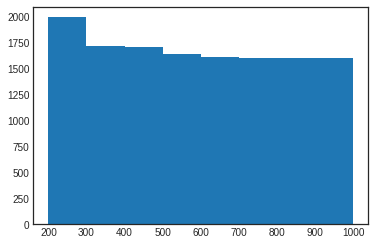

In [ ]:
print(data[columns_numerical].describe())

display(Markdown("#### Number of Victim Age = 0 "))
print(data[data['Victim Age'] == 0].shape[0])
print(pd.crosstab(data['Crime Solved'], data['Victim Age']==0, normalize='index'))

display(Markdown("#### Number of Victim Age > 99 "))
print(data[data['Victim Age'] > 99].shape[0])
print(data[data['Victim Age'] == 998].shape[0])
print(pd.crosstab(data['Crime Solved'], data['Victim Age']>99, normalize='index'))

display(Markdown("#### Number of Perpetrator Age = 0 "))
print(data[data['Perpetrator Age'] == 0].shape[0])
print(pd.crosstab(data['Crime Solved'], data['Perpetrator Age']==0, normalize='index'))

display(Markdown("#### Histogram for Incident > 199 to get a better overview of the column's structure "))
plt.hist(data[data['Incident'] > 199]['Incident'], bins= 8) # also see without restriction on incident and bins=10

* **`Incident` seems to have a rather curious data structure**: A lot of the distribution is around 0 to 100 with some between 100 and 200 and then we have a nearly uniform distribution between 200 and 999. Since we could not find any documentation on what the incident attribute stands for, we will not include it into our model to prevent any unexplainable bias.
* There are **few victims with ages equal to 0**. We will not change this to NaN values since it is still possible that a baby was murdered. Furthermore the distribution of age = 0 between solved and unsolved crime seems to be logical with three times more solved crimes than unsolved crimes.
* There are 974 observations where the **victim age is equal to 998**. This is four-times more likely when the crime was not solved. We assume that these are cases of wrongly attributed ages and will set those values to NaN
* We notice that about a third of all the `Perpetrator Age` is set to 0. With 99.6% of unsolved crimes having a perpetrator's age of 0. It seems very unlikely that babies are responsible for so many murders. It's rather plausible that instead of coding `Perpetrator Age` with NaN it was coded with 0 in this data set. That is why **we will have to exclude `Perpetrator Age`** in our model for the solved crime as well.

In [ ]:
cols_to_drop = ['Perpetrator Age','Incident']
data.drop(columns=cols_to_drop, inplace=True)
columns_numerical.remove('Perpetrator Age')
columns_numerical.remove('Incident')
cols_to_drop = []

data[data['Victim Age'] > 99] = np.nan
print(data[columns_numerical].describe())

               Year     Victim Age
count  637480.00000  637480.000000
mean     1995.79507      33.562204
std         9.92599      17.792594
min      1980.00000       0.000000
25%      1987.00000      22.000000
50%      1995.00000      30.000000
75%      2004.00000      42.000000
max      2014.00000      99.000000


To make our lives easier we will now add a column `Race` denoting People of Color. This attribute will be encoded with `White`, `PoC`.

In [ ]:
data['Race'] = np.where(data['Victim Race'] == 'White', 'White', 'PoC')
columns_categorical = columns_categorical + ['Race']
data.head()

,Record ID,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Weapon,Victim Count,Perpetrator Count,Record Source,Race
0,1.0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,January,Murder or Manslaughter,Yes,Male,14.0,Native American/Alaska Native,Blunt Object,0.0,0.0,FBI,PoC
1,2.0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,Murder or Manslaughter,Yes,Male,43.0,White,Strangulation,0.0,0.0,FBI,White
2,3.0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,Murder or Manslaughter,No,Female,30.0,Native American/Alaska Native,NaN,0.0,0.0,FBI,PoC
3,4.0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,Murder or Manslaughter,Yes,Male,43.0,White,Strangulation,0.0,0.0,FBI,White
4,5.0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,Murder or Manslaughter,No,Female,30.0,Native American/Alaska Native,NaN,0.0,1.0,FBI,PoC


# 2. AIF360 Tool <a class="anchor" id="chapter2"></a>

In our investigation we will apply the metrics and bias mitigation algorithms of the AIF360 toolkit by Bellamy et al.: 
"This extensible open source tool kit can help you examine, report, and mitigate discrimination and bias in machine learning models throughout the AI application lifecycle" (Bellamy et al. 2018). \\
The code is available in Python and R. If you want to know more about how to use the toolkit please have a look at IBM's official website listed below.   
In this project we rely on the documentation and demonstration code given in the GitHub repository.   
   
Official website: https://aif360.mybluemix.net.  
Documentation can be found here: https://aif360.readthedocs.io/en/latest/index.html   
Official GitHub repository can be found here: https://github.com/Trusted-AI/AIF360  

## 2.0 Installing the AIF360 Tool & Loading respective packages
Since it is not a standard in the google colab environment, we need to install AIF360 first. 

In [ ]:
!pip install 'aif360[all]'

     |████████████████████████████████| 175 kB 12.0 MB/s 
     |████████████████████████████████| 21.2 MB 1.4 MB/s 
     |████████████████████████████████| 9.1 MB 80.2 MB/s 
     |████████████████████████████████| 275 kB 73.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 
     |████████████████████████████████| 2.6 MB 58.2 MB/s 
     |████████████████████████████████| 3.4 MB 51.6 MB/s 
     |████████████████████████████████| 25.3 MB 60 kB/s 
     |████████████████████████████████| 548 kB 78.6 MB/s 
     |████████████████████████████████| 356 kB 71.9 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=3a54ad22d0ab4f138848641aa2a8438bac902cdd7f144956984b9d80c0b67086
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d785e37da3704f13e0fdc1fb681bf0c3d2709dccc8d7bf32da70f

In [ ]:
!pip install fairlearn

In [ ]:
# packes from aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

#more packages needed for this analysis
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier

## 2.1 Data cleaning and re-encoding for the AIF special format "StandardDataset"
To be able to work with our dataset we transform the categorical columns into numerical columns with the label encoder and scale all truely numerical columns to [0,1] with the MinMaxScaler.

In [ ]:
data_encoded = data.copy() #make copy of data

categorical_names = {}
encoders = {}

#categorical_features_index = [np.where(data.columns.values == col)[0][0] for col in columns_categorical]
display(Markdown("#### Again - our categorical columns:"))
print(columns_categorical)

# Use Label Encoder for categorical columns (including target column)
# Label Encoder transforms categorical columns to numerical columns with a label encoding
for feature in columns_categorical:
    le = LabelEncoder()
    #print(data_encoded[feature])
    le.fit(data_encoded[feature].astype(str))
    
    data_encoded[feature] = le.transform(data_encoded[feature].astype(str))
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

numerical_features = [c for c in data.columns.values if c not in columns_categorical]
display(Markdown("#### Again - our numerical columns:"))
print(numerical_features)


for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

display(Markdown("#### Encoded Data Frame now looks like this:"))
data_encoded.head()

#### Again - our categorical columns:

['Agency Name', 'Agency Type', 'City', 'State', 'Month', 'Crime Type', 'Victim Sex', 'Victim Race', 'Weapon', 'Record Source', 'Crime Solved', 'Victim Count', 'Perpetrator Count', 'Race']


#### Again - our numerical columns:

['Record ID', 'Year', 'Victim Age']


#### Encoded Data Frame now looks like this:

,Record ID,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Weapon,Victim Count,Perpetrator Count,Record Source,Race
0,0.000000,148.0,1.0,35.0,1.0,0.0,4.0,1.0,1.0,1.0,0.141414,2.0,0.0,0.0,0.0,0.0,0.0
1,0.000002,148.0,1.0,35.0,1.0,0.0,7.0,1.0,1.0,1.0,0.434343,3.0,13.0,0.0,0.0,0.0,1.0
2,0.000003,148.0,1.0,35.0,1.0,0.0,7.0,1.0,0.0,0.0,0.303030,2.0,15.0,0.0,0.0,0.0,0.0
3,0.000005,148.0,1.0,35.0,1.0,0.0,0.0,1.0,1.0,1.0,0.434343,3.0,13.0,0.0,0.0,0.0,1.0
4,0.000006,148.0,1.0,35.0,1.0,0.0,0.0,1.0,0.0,0.0,0.303030,2.0,15.0,0.0,1.0,0.0,0.0


For our first analysis we want the protected attribute to be **`Victim Race`** with the priviledged value being `White`.

In [ ]:
privileged_race = np.where(categorical_names['Race'] == 'White')[0]
privileged_race # via Label Encoder the category 'White' equals 3

array([1])

We can now build our StandardDataset for the AIF360 tool. To do this we have to tell the dataset our dependent variable (`Crime Solved`) and which of its values corresponds to the favorable class (which is `1 = Yes`) as well as the protected attribute and its priviledged class (`Victim Race` and `White`).   
StandardDataset will automatically remove any observations with NaN values. In this case we have the 974 observations where `Victim Age` was 998 years and thus set to NaN (see above).

In [ ]:
  data_race = StandardDataset(data_encoded, 
                               label_name='Crime Solved', 
                               favorable_classes=[1], 
                               protected_attribute_names=['Race'], 
                               privileged_classes=[privileged_race])
  
  #tmp = data_race.convert_to_dataframe()
  #tmp[0] # this is how you can access the pure data from the Standard Dataset. Thus tmp[0] == data_encoded
  data_race

               instance weights  features  ...                     labels
                                           ... protected attribute       
                                Record ID  ...                Race       
instance names                             ...                           
0                           1.0  0.000000  ...                 0.0    1.0
1                           1.0  0.000002  ...                 1.0    1.0
2                           1.0  0.000003  ...                 0.0    0.0
3                           1.0  0.000005  ...                 1.0    1.0
4                           1.0  0.000006  ...                 0.0    0.0
...                         ...       ...  ...                 ...    ...
638449                      1.0  0.999994  ...                 1.0    0.0
638450                      1.0  0.999995  ...                 1.0    1.0
638451                      1.0  0.999997  ...                 0.0    1.0
638452                      1.0  0.999

Using this code snippet from the example GitHub code, we can check all the characteristics of our StandardDataset.

In [ ]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [ ]:
meta_data(data_race)

#### Dataset shape

(637480, 16)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Record ID', 'Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source', 'Race']


To evaluate if our model is fair and "how" fair it is we first need to create a model. To do so we create a train and test split. We actively decided against a training-validation-test split since this project is not about finding the best model but about evaluating the fairness methods. To properly train a model you should in any case use a three-splitted dataset and at best also use cross-validation.   
Looking at the crosstables we seem to have a good split between the training and test data.

In [ ]:
np.random.seed(42)

data_race_train, data_race_test = data_race.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print(data_race_train.features.shape)
print(pd.crosstab(data_race_train.convert_to_dataframe()[0]['Crime Solved'], data_race_train.convert_to_dataframe()[0]['Race'] == 1, normalize='index'))
display(Markdown("#### Test Dataset shape"))
print(data_race_test.features.shape)
print(pd.crosstab(data_race_test.convert_to_dataframe()[0]['Crime Solved'], data_race_test.convert_to_dataframe()[0]['Race'] == 1, normalize='index'))

#### Train Dataset shape

(446236, 16)
Race             False     True 
Crime Solved                    
0.0           0.567225  0.432775
1.0           0.475011  0.524989


#### Test Dataset shape

(191244, 16)
Race             False     True 
Crime Solved                    
0.0           0.565370  0.434630
1.0           0.475008  0.524992


## 2.2 Training a very simple random forest
For a very naive classification we train a simple random forest (takes about 2m). As we defined as a input for our StandardDataset the `label_name = Crime Solved` the random forest will predict an outcome of `1 = Crime was solved`or `0 = crime was not solved`. After the training we evaluate the accuracy and give a confusion matrix. We know that we have an unblanced data set since the about 70% of all observations in the test set are solved crimes. Thus the accuracy of our random forest is okay-ish with about 76%.

In [ ]:
rf_race = RandomForestClassifier().fit(data_race_train.features, 
                     data_race_train.labels.ravel(), 
                     sample_weight=data_race_train.instance_weights)

In [ ]:
X_test_race = data_race_test.features
y_test_race = data_race_test.labels.ravel()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

accuracy, confusion_matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test_race, y_test_race, rf_race.predict(X_test_race), rf_race.predict_proba(X_test_race))

display(Markdown("#### Percent of Crime Solved = 1"))
print(np.mean(y_test_race))
display(Markdown("#### Accuracy on Test Set"))
print(accuracy)
display(Markdown("#### Confusion Matrix"))
print(confusion_matrix)

#### Percent of Crime Solved = 1

0.702479554914141


#### Accuracy on Test Set

0.757618539666604


#### Confusion Matrix

[[ 26775  30124]
 [ 16230 118115]]


# 3. Bias Detection <a class="anchor" id="chapter3"></a>



If bias is to be mitigated in a data set or model, it must first be detected. For this purpose, we will explain fairness definitions and metrics we consider important in this section. Afterwards we are going to apply them to the random forest model under consideration and evaluate whether and if so, to which extent it is biased.\
There are over 20 different definitions of fairness in literature, some of which overlap and contradict each other. The definitions can be roughly divided into Group and Individual Fairness. 
In Group Fairness different groups should be treated euqally, whereas in Individual Fairness similar individuals should reiceive similar predictions (Mehrabi et al. 2019). Here, the group fairness definitions in particular are taken into account. All existing fairness metrics are based on fairness definitions. The metrics presented here form the basis for the bias mitigation algorithms considered later.

For reusability, we implemented a method that computes a given fairness metric on a given model and dataset. Therefore we determine the privileged and unprivileged group of the protected attribute `Victim Race`. The privileged group is assigned to all victims being white and the unprivileged group is assigned to all remaining categories.

In [ ]:
privileged_groups = [{'Race': 1}]
unprivileged_groups = [{'Race': 0}] # careful: some function can not handle more than 1 unpriviledged group -> you will have to convert these into a binary group beforehand

In [ ]:
def calc_fairness(ori_dataset, predicted_values, privileged_groups, unprivileged_groups, fair_metric, printout = True):
  # for predicted_values run: model.predict(ori_dataset.features)
  pred_dataset = ori_dataset.convert_to_dataframe()[0]
  pred_dataset[ori_dataset.label_names[0]] = predicted_values
  pred_dataset = StandardDataset(pred_dataset, 
                               label_name=ori_dataset.label_names[0], 
                               favorable_classes=[1], 
                               protected_attribute_names=['Race'], 
                               privileged_classes=[privileged_race])

          
  classified_metric = ClassificationMetric(ori_dataset,
                                              pred_dataset,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  metric_pred = BinaryLabelDatasetMetric(ori_dataset,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  row = calc_fairness_single(classified_metric, metric_pred, fair_metric)
  acc = classified_metric.accuracy()
  if printout:
    display(Markdown("#### Fairness metric:"))
    print(fair_metric,": ", row)
    display(Markdown("#### Accuracy:"))
    print(acc)
  else:
    return row, acc


def calc_fairness_single(classified_metric, metric_pred, fair_metric):
  #should be 0
  if fair_metric == "equal opportunity":
    return classified_metric.equal_opportunity_difference()
  #should be 1, <1 prefers privileged, >1 prefers unprivileged
  elif fair_metric == "disparate impact":
    return metric_pred.disparate_impact()
  #should be 0
  elif fair_metric == "equalized odds":
    return classified_metric.average_odds_difference()
  #should be 0
  elif fair_metric == "statistical parity":
    return metric_pred.mean_difference()

All equations of our 4 fairness metrics are from the documentation of the AIF360, available via \\
https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html

## 3.1 Statistical Parity / Demographical Parity

"The likelihood of a positive outcome should be the same regardless of whether the person is in the protected group." (Mehrabi et al 2019)

**Definition**: (Verma & Rubin 2018) \\
\begin{equation}
P(d = 1 | G = privileged) = P(d = 1 | G = unprivileged) 
\end{equation}

In other words, the sum of True Positves and False Postives should be the same for all groups of the protected attribute.

**Metric for Statistical Parity**: 
\begin{equation}
P(d = 1 | G = unprivileged) - P(d = 1 | G = privileged)
\end{equation}

In order for a dataset or model to be fair, the statistical parity should be 0.


Let's have a look at Statistical Parity Metric for our random forest model trained with the Homicide dataset. First we have to generate the predictions of the random forest, so that they can be fed into the method calc_fairness implemented above.

In [ ]:
prediction = rf_race.predict(data_race_test.features)
calc_fairness(data_race_test, prediction, privileged_groups, unprivileged_groups, "statistical parity")

#### Fairness metric:

statistical parity :  -0.07554431748492474


#### Accuracy:

0.757618539666604


The calculated value for statistical parity is -0.075 and indicates that the model is slightly biased. Non-surprisingly it prefers the privileged group (white group). This would mean that more crimes were solved of where victims were white. 

##3.2 Equalized odds

"[...] The probability of a person in the positive class being correctly assigned a positive outcome and the probability of a person in a negative class being incorrectly assigned a positive outcome should both be the same for the protected and unprotected group members." (Mehrabi et al. 2019)

**Definition**: (Verma & Rubin 2018) \\

\begin{equation}
P(d = 1|Y = 1, G = privileged) = P(d = 1|Y = 1, G = unprivileged)\\
which\ also\ holds\ for\ Y = 0.
\end{equation}


In other words, protected and unprotected groups should have the same True-Postive and False-Positive Rates. 

**Metric for Equalized Odds**:
\begin{equation}
\frac{1}{2}[(FPR_{D=unprivileged}−FPR_{D=privileged})+(TPR_{D=unprivileged}−TPR_{D=privileged}))]
\end{equation}

In order for a dataset or model to be fair, equalized odds should be 0.


Reminder: \

\begin{equation}
TPR = \frac{TP}{TP+FN}
\end{equation}
\
\begin{equation}
FPR = \frac{FP}{FP+TN}
\end{equation}


Let's have a look at the Equalized Odds Metric for our random forest model trained with the Homicide dataset. 

In [ ]:
calc_fairness(data_race_test, prediction, privileged_groups, unprivileged_groups, "equalized odds")

#### Fairness metric:

equalized odds :  -0.10529814146290331


#### Accuracy:

0.757618539666604


The calculated value for Equalized Odds is -0.105 which indicates that the model is biased because it differs from 0. Compared to Statistical Parity, equalized odds shows a stronger bias in the model. Both metrics indicate that the model favors the white group. 

##3.3 Equal Opportunity

"[...] The probability of a person
in a positive class being assigned to a positive outcome should be equal for both protected and
unprotected group members" (Mehrabi et al. 2019)

**Definition**: (Verma & Rubin 2018) \\
\begin{equation}
TPR_{D=unprivileged} = TPR_{D=privileged}
\end{equation}


In other words, same True Postive Rates for all groups of the protected attribute.

**Metric for Equal Opportunity**: 
\begin{equation}
TPR_{D=unprivileged} - TPR_{D=privileged}
\end{equation}

In order for a dataset or model to be fair, equal opportunity should be 0.


Let's have a look at the Equal Opportunity metric for our random forest model trained with the Homicide dataset. 

In [ ]:
calc_fairness(data_race_test, prediction, privileged_groups, unprivileged_groups, "equal opportunity")

#### Fairness metric:

equal opportunity :  -0.06753600044098129


#### Accuracy:

0.757618539666604


Since the value -0.068 differs from 0, also Equal Opportunity shows that the model is slightly biased. Not as strong as Equalized Odds, but similar to Statistical parity. Similar to Statistical Parity and Equalized Odds it indicates that the privileged group (white group) is favored by the model.

##3.4 Disparate Impact 

For Disparate Impact the ratio of all instances in the positive/favorable class with respect to membership of the protected or unprotected group is calculated. 
\begin{equation}
\frac{P(Y=1|D=unprivileged)}{P(Y=1|D=privileged)}
\end{equation}

In order for a dataset or model to be fair, Disparate Impact should be 1.
A Disparate Impact value smaller than 1 indicates that the privileged group is favored by the model. Similarly, a Disparate Impact value greater than 1 indicates that the unprivileged group is favored.

Let's have a look at the Disparate Impact in our random forest model trained with the Homicide dataset. 

In [ ]:
calc_fairness(data_race_test, prediction, privileged_groups, unprivileged_groups, "disparate impact")

#### Fairness metric:

disparate impact :  0.8979675076759687


#### Accuracy:

0.757618539666604


The calculated value for Disparate Impact is 0.898 which is smaller than 1. Therefore the model favors the privileged group (white group) similar to previous metrics under consideration. Feldman et al. 2015 state that a DI value above 0.8 is considered to be fair because it is advocated by the US Equal Employment Opportunity Commission (EEOC). A different value might be considered acceptable from a different organization in Europe.

#4. Bias Mitigation <a class="anchor" id="chapter4"></a>

Following the investigation by Bellamy et al., we can now try to mitigate the detected bias in our model. To do this, we apply selected bias mitigation algorithms of the  AIF360 toolkit to our random forest. The nine algorithms of the tool are divided into pre-, in- and post-processing techniques and are based on previous research. An overview is given in the following table which is closely related to the work of Bellamy et al. We will apply four selected algorithms here. All bias mitigation algorithms were designed to attempt to satisfy one or more fairness metrics. 

| | Application | Bias Mitigation Algorithm | Source |
| --- | --- | --- | ---|
| **Pre-Processing** | If it's possible to modify training data |  1. Reweighing | (Kamiran \& Calders 2012)|
| | | 2. Optimized Pre-processing | (Calmon et al. 2017)|
| | | 3. Learning Fair Representations |  (Zemel et al. 2013)|
| | | 4. Disparate Impact Remover | (Feldman et al. 2015) |
| **In-Processing** | If it's possible to change algorithm during training | 5. Adversarial Debiasing | (Zhang et al. 2018) |
| | | 6. Prejudice Remover | (Kamishima et al. 2012) |
| **Post-Processing** | Last chance, if algorithm is a black box | 7. Reject Option Classification | (Kamiran et al. 2012)
| | | 8. Equalized Odds Post-processing | (Hardt et al. 2016)|
| | | 9. Calibrated Equalized Odds Post-processing | (Pleiss et al. 2017)|

## 4.1 Pre-processing 

Pre-processing is done before training a model. Here, only the dataset that will later be fed into a model is modified.  


###1. Reweighing

In Reweighing (Kamiran & Calders, 2012) each training example is assigned to a weight before training. The weights are based upon their category of the protected attribute and target output (meaning the actual output, not the predicted one, as we don't need our random forest here). The weights are adjusted such that the discrimination is reduced to zero while the overall positive class probability maintains the same. 
The accuracy of our Random Forest stays the same before and after application, because Reweighing only modifies the data set. 

Our data set was already provided with initial instance weights of 1.0 when creating the StandardDataset of AIF360. In this section we want to adjust these weights by applying Reweighing to the data so that we can compensate for the bias in the data set.

In [ ]:
data_race_train

               instance weights  features  ...                     labels
                                           ... protected attribute       
                                Record ID  ...                Race       
instance names                             ...                           
401732                      1.0  0.629227  ...                 0.0    1.0
248795                      1.0  0.389684  ...                 1.0    1.0
619460                      1.0  0.970252  ...                 0.0    1.0
173469                      1.0  0.271702  ...                 0.0    1.0
87124                       1.0  0.136461  ...                 1.0    0.0
...                         ...       ...  ...                 ...    ...
44166                       1.0  0.069177  ...                 0.0    1.0
202125                      1.0  0.316586  ...                 1.0    1.0
448572                      1.0  0.702592  ...                 0.0    0.0
301716                      1.0  0.472

In order to ultimately determine whether the application of the Reweighing algorithm had an effect, we first need a metric that measures the bias prior to our application in the Homicide dataset. In this case, Statistical Parity is used, because Reweighing is based on this metric due to the fact that it evalutes the protected attribute and target class. Let's have a look!

In [ ]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(data_race_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in statistical parity outcomes between unprivileged and privileged groups = -0.077098


According to the authors of Reweighing, a data set is unbiased if the protected attribute and the target class are statistically independent (Kamiran & Calders 2012). This is not the case here. As mentioned in the bias detection section, we can see that our dataset is not completely free of bias, as the Statistical Parity slightly differs from 0. A Statistical Parity of -0.077 means that the privileged group is favored by our dataset.  

Let us apply the Reweighing algorithm so that we can compensate for the measured bias. To do this, we first call the constructor to create a Reweighing object. Then we fit it with our original training set "data_race_train" and transform it by assigning a weight to each example.  Each weight is composed of membership in the privileged or unprivileged group and membership in the favored or unfavored class. In this case: Weights are assigned with respect to being white (privileged) or PoC (unprivileged) and whether the crime was solved (favorable) or not (unfavorable).

In [ ]:
reweighing = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
reweighing.fit(data_race_train)
data_train_reweighed = reweighing.transform(data_race_train)

In [ ]:
### Testing whether weighting worked correctly
assert np.abs(data_train_reweighed.instance_weights.sum()-data_race_train.instance_weights.sum())<1e-6


As we now applied Reweighing to out training set, let's check whether it is free of bias by calculating the Statistical Parity of the transformed data. 

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(data_train_reweighed, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())


#### Transformed training dataset

Difference in statistical parity outcomes between unprivileged and privileged groups = -0.000000


As can be seen from the new statistical parity value of 0, Reweighing successfully eliminated the bias from our dataset by adjusting the weights of each observation accordingly. 
Our protected attribute `Race` and the class `Crime Solved` are no longer statiscally dependent. Thus, our dataset no longer favors the privileged (white) group. Let's see how the instance weights have changed after the procedure. 

In [ ]:
data_train_reweighed

               instance weights  features  ...                     labels
                                           ... protected attribute       
                                Record ID  ...                Race       
instance names                             ...                           
401732                 1.057764  0.629227  ...                 0.0    1.0
248795                 0.947735  0.389684  ...                 1.0    1.0
619460                 1.057764  0.970252  ...                 0.0    1.0
173469                 1.057764  0.271702  ...                 0.0    1.0
87124                  1.149675  0.136461  ...                 1.0    0.0
...                         ...       ...  ...                 ...    ...
44166                  1.057764  0.069177  ...                 0.0    1.0
202125                 0.947735  0.316586  ...                 1.0    1.0
448572                 0.885803  0.702592  ...                 0.0    0.0
301716                 0.885803  0.472

We can see that the weights no longer have initial values 1.0. We adjusted them successfully according to Statistical Parity, so that the data set is no longer biased. The transformed dataset could now be used to train any classifier.

###4. Disparate Impact Remover

The Disparate Impact Remover (Feldman et al. 2015) (DIR) aims to optimize the already mentioned Disparate Impact Fairness Metric (see the paragraph for bias detection) in a dataset. To achieve this it takes into account the distribution of all unprotected attributes (Y) given the values of the protected attributes (X). In our case this would be `x = White` and `x = PoC`. When we have bias in our data we have a different cummulative distribution functions (cdf)
\begin{equation}
 F_{White}(Y=y)\ and\ F_{PoC}(Y=y)
\end{equation}
DIR now changes the values of all y in Y so that the cdfs match whilst preserving the rank of each observation. This means if the age of a white victim was 34 and thus had the rank of let's say 124 it might now be assigned the age of 23 whilst keeping it's rank of 124 in the white group. Same happens for the PoC group. 
<br />  
To control for the matching of the cdfs a parameter called `repair level` is used. For completely matching cdfs the repair level is equal to 1. If we still want to allow for slight differences in the cdfs of the repective groups we can lower the repair level. A reason to do this might be to keep some information about the groups to train our model on. On the other hand we shouldn't keep to much information since we are trying to mitigate bias. A repair level of 0 is the same as if we didn't use DIR at all.   
<br />
A very nice visualisation of how the repair level works can be found here:    
https://towardsdatascience.com/ai-fairness-explanation-of-disparate-impact-remover-ce0da59451f1

In [ ]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric

In [ ]:
protected = 'Race'

The Disparate Impact Remover takes about an hour with the whole dataset to run through the process. Since we want to find the optimal parameter for the repair level (in [0,1]) we need to run a loop for different values of the repair level. This would result in an one hour run per loop.   
For demonstration purpose we generate a small random sample from the whole dataset on which we run the Disparate Impact Remover.   
Results for the whole dataset can be found below as a picture. If you want to regenerate this picture please run the code below with `whole_dataset = True`.   
`num_points` defines the number of values for the repair level to be visited and later drawn in the diagram. It's currently set to 6 (steps of 0.2) to reduce runtime. However feel free to experiment.

In [ ]:
whole_dataset = False
num_points = 6

if whole_dataset:
  data_DIR_train = data_race_train.copy()
  data_DIR_test = data_race_test.copy()
else:
  np.random.seed(3456)
  d_train_min, _ = data_race_train.split([0.05], shuffle=True)
  d_test_min, _ = data_race_test.split([0.05], shuffle=True)
  data_DIR_train = d_train_min
  data_DIR_test = d_test_min

For every repair level we first apply the DIR (line 7-9) to our StandardDataset, both for the training and test set. Then we split our training and test sets into our features (X) and our classification variable (y) (line 11-14) before training a new Random Forest on the training set (line 20). Last we predict the new classification on the test set (line 22-23) and calculate the Disparate Impact and accuracy (line 25-27).

In [ ]:
index = data_race_train.feature_names.index(protected) # location of column of the protected attribute

DIs = []
ACCs = []

for level in tqdm(np.linspace(0., 1., num_points)): # every 0.2
    dir = DisparateImpactRemover(repair_level=level)
    train_trans_DIR = dir.fit_transform(data_DIR_train) 
    test_trans_DIR = dir.fit_transform(data_DIR_test) 
    
    X_tr = np.delete(train_trans_DIR.features, index, axis=1)
    X_te = np.delete(test_trans_DIR.features, index, axis=1)
    y_tr = train_trans_DIR.labels.ravel()
    y_te = test_trans_DIR.labels.ravel()
    
    # if you want a logistic regression use this here:
    #lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    #lmod.fit(X_tr, y_tr)

    rf_mod = RandomForestClassifier().fit(X_tr, y_tr)
    
    test_trans_pred = test_trans_DIR.copy()
    test_trans_pred.labels = rf_mod.predict(X_te)

    calcmetric = BinaryLabelDatasetMetric(test_trans_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    DIs.append(calcmetric.disparate_impact())
    ACCs.append(accuracy_score(y_te, test_trans_pred.labels))

100%|██████████| 6/6 [00:43<00:00,  7.23s/it]


We now plot the Disparate Impact (DI) (blue line) and accuracy (yellow line). The green and red line show the preferred bounds for DI with the red line being 0.8 and the green line being at 1.0. Thus any DI above the green line is an overshooting of the DIR algorithm, now favouring the unpriviledged group. Everything between the red and the green line is considered to be an acceptable value for the DI according to Feldman et al. 2015.

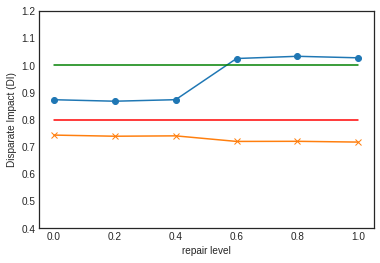

[0.8730737561527749, 0.8675821918772759, 0.8731762794119393, 1.0246725375957972, 1.0328287617597163, 1.0272046914940403]
[0.7429408073624765, 0.7387575820957959, 0.7401171303074671, 0.719619326500732, 0.7200376490274001, 0.7172139719723907]


In [ ]:
%matplotlib inline

plt.plot(np.linspace(0, 1, num_points), DIs, marker='o')
plt.plot(np.linspace(0, 1, num_points), ACCs, marker='x')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

print( DIs)
print(ACCs)

These are the results when running the DIR on the whole dataset:

<img src= 'https://github.com/BiancaZimmer/Stat-ML-Fairness/raw/22c2b912580e460eecb23b95ce4ffe1a51c59634/DIR_wholeDataset.png' />

We can see that the DI only slightly worsens from repair level 0 to 0.2 afterwards the DI slightly improves with each repair level step. The improvement is only 0.0364. However our DI is greater than 0.8 and thus deemed acceptable. Improvement is always possible, though. The accuracy drops as expected but also only very slightly from 74.11% to 74.08%.   
The DIR does not seem to work very well with our dataset as it does not improve the DI profoundly. However when we look at a smaller portion of the dataset the DIR seems to work quite well or even overshoot (DI > 1). It might be that DIR is a method for smaller datasets and not well suited for bigger ones. This a topic that should be explored in the future.

## 4.2 In-Processing
In-processing happens during training. The model itself is modified by changing the objective function or imposing certain constraints. 

###5. Adversarial Debiasing

Adversarial Debiasing (Zhang et al. 2018) is a supervised deep learning approach, where two networks are built: 
1. The predictor model makes predictions based on the regular data set.
2. The adversary model takes the output of the predictor model as input and tries to predict the protected attribute. 

Both networks then compete against each other while the predictor's goal is to prevent the adversary from determining the protected attribute.   

Since Adverserial Debiasing (AD) is a method based on deep neural networks (DNN) we can not use our random forest classifier as a basis. We will use the implemented DNNs which AIF360 uses for the AD.

In [ ]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

As a reminder we compute the Statistical Parity differences for the test and training datasets:

In [ ]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(data_race_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training and test dataset"))
print("Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(data_race_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training and test dataset

Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = -0.077098
Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = -0.075544


As stated above we now have to divert from our random forest classifier and first train a plain DNN model with tensorflow. For this purpose we first specify all our parameters for the DNN:   

In [ ]:
#tf.reset_default_graph() # use if you want to rerun the model
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess,
                          num_epochs = 5)

Since AD needs a few minutes (about 5) to run on the whole dataset you can set `whole_dataset = False` to generate quicker results on a smaller subset of the data. However be aware that AD is a method using DNN and thus generally performs better the more data it has as an input.

In [ ]:
whole_dataset = True

if whole_dataset:
  data_AD_train = data_race_train.copy()
  data_AD_test = data_race_test.copy()
else:
  np.random.seed(3456)
  d_train_min, _ = data_race_train.split([0.2], shuffle=True)
  d_test_min, _ = data_race_test.split([0.2], shuffle=True)
  data_AD_train = d_train_min
  data_AD_test = d_test_min

Now let's train our plain DNN on the training data:

In [ ]:
plain_model.fit(data_AD_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 129.387970
epoch 0; iter: 200; batch classifier loss: 27.149780
epoch 0; iter: 400; batch classifier loss: 8.194244
epoch 0; iter: 600; batch classifier loss: 1.868647
epoch 0; iter: 800; batch classifier loss: 1.334041
epoch 0; iter: 1000; batch classifier loss: 0.782996
epoch 0; iter: 1200; batch classifier loss: 0.706884
epoch 0; iter: 1400; batch classifier loss: 0.680930
epoch 0; iter: 1600; batch classifier loss: 0.699754
epoch 0; iter: 1800; batch classifier loss: 0.645440
epoch 0; iter: 2000; batch classifier loss: 0.787780
epoch 0; iter: 2200; batch classifier loss: 0.561749
epoch 0; iter: 2400; batch classifier loss: 0.556623
epoch 0; iter: 2600; batch classifier loss: 0.661307
epoch 0; iter: 2800; batch classifier loss: 0.687406
epoch 0; iter: 3000; batch classifier loss: 0.583508
epoch 0; iter: 3200; batch classifier loss: 0.551651
epoch 0; iter: 3400; batch classifier loss: 0.653563
epoch 1; iter: 0; batch classifier loss: 0.667216


The classifier loss looks good. It already drops profoundly during the first epoch. We probably would not have needed to train for 25 epochs. When you are training the DNN on a smaller subset of the data it needs a few more epochs to reach the same loss value.   

We now apply our plain model to the train and test data set and compare the metrics:

In [ ]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(data_AD_train)
dataset_nodebiasing_test = plain_model.predict(data_AD_test)

In [ ]:
def calc_ADmetrics(dataset_train_pred, dataset_test_pred):
  display(Markdown("#### Dataset metrics"))
  metric_dataset_train_pred = BinaryLabelDatasetMetric(dataset_train_pred, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  print("Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_dataset_train_pred.mean_difference())

  metric_dataset_test_pred = BinaryLabelDatasetMetric(dataset_test_pred, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  print("Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_dataset_test_pred.mean_difference())

  display(Markdown("#### Classification metrics"))
  classified_metric_test = ClassificationMetric(data_AD_test, #careful, hardcoded
                                                  dataset_test_pred,
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)
  print("Test set: Classification accuracy = %f" % classified_metric_test.accuracy())
  TPR = classified_metric_test.true_positive_rate()
  TNR = classified_metric_test.true_negative_rate()
  bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
  print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
  print("Test set: Disparate impact = %f" % classified_metric_test.disparate_impact())
  print("Test set: Equal opportunity difference = %f" % classified_metric_test.equal_opportunity_difference())
  print("Test set: Average odds difference = %f" % classified_metric_test.average_odds_difference())

In [ ]:
display(Markdown("#### Plain model - without debiasing"))
calc_ADmetrics(dataset_nodebiasing_train, dataset_nodebiasing_test)

#### Plain model - without debiasing

#### Dataset metrics

Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000


#### Classification metrics

Test set: Classification accuracy = 0.702480
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = 1.000000
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000


When we look at the results we notice that Statistical Parity has already dropped to 0 although we didn't even use AD but simply trained a DNN. When looking at the classification accuracy we can see that it is at 70.25% which is equal to the proportion of solved crimes. Our DNN didn't learn anything and is simply guessing. Since we do not focus on finding a good model in this jupyter notebook but rather on using the bias mitigation methods we did not investigate further how to improve the model.   
Another reason why we didn't try to improve the DNN model is that the AD function implemented in AIF360 seems to be very inflexible. One would have to rewrite parts of the base code of their function to actually improve the DNN. This is out of the scope of this project.   
If you still want to use AD, we would advise you to improve the DNN by getting more training data, tweaking the learning rate and batch size as well as the underlying layers by e.g. adding a dropout layer.   
Another big drawback of the implementation of the AIF360 function is not being able to optimize for validation loss since there is no possibility to put in a validation dataset as a parameter into the function.  

To be fair: A model which is only guessing the response variable is the fairest model one can get. You can also see this looking at the bias metrics: None of them indicate any bias. However a model which assigns the response by chance is of course useless in practice. 

Even though we a have a model which guesses whether a crime was solved or not we still want to show how an implementation for AD would look like.

We now re-train our DNN model with the debiasing option turned on (`debias = True`) and again compute the metrics for train and test dataset.

In [ ]:
# important to close and reopen tesorflow session for a new tf model
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [ ]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess,
                          num_epochs = 5)
# parameter adversary_loss_weight = 0.1 not used because no effect can be seen in our context

In [ ]:
debiased_model.fit(data_AD_train)

epoch 0; iter: 0; batch classifier loss: 180.321640; batch adversarial loss: 0.811245
epoch 0; iter: 200; batch classifier loss: 33.545601; batch adversarial loss: 0.842707
epoch 0; iter: 400; batch classifier loss: 3.947190; batch adversarial loss: 0.742144
epoch 0; iter: 600; batch classifier loss: 2.890715; batch adversarial loss: 0.695410
epoch 0; iter: 800; batch classifier loss: 1.312801; batch adversarial loss: 0.689426
epoch 0; iter: 1000; batch classifier loss: 1.283877; batch adversarial loss: 0.693547
epoch 0; iter: 1200; batch classifier loss: 0.760577; batch adversarial loss: 0.697991
epoch 0; iter: 1400; batch classifier loss: 0.871973; batch adversarial loss: 0.696279
epoch 0; iter: 1600; batch classifier loss: 0.648640; batch adversarial loss: 0.675771
epoch 0; iter: 1800; batch classifier loss: 0.640385; batch adversarial loss: 0.671011
epoch 0; iter: 2000; batch classifier loss: 0.662157; batch adversarial loss: 0.702880
epoch 0; iter: 2200; batch classifier loss: 0.6

Looking at the loss metrics which are given during the model training we can now see the loss of the classifier (our model which we will obtain at the end) and the loss of the adversarial model.    
Both losses do not change much after the first epoch similar to the plain DNN model. However we can see that the classifier loss starts at a very high value (similiar to the plain model) whereas the adversarial loss starts at about 0.7. Remember: The adversarial model tries to predict the protected attribute with the prediction of the classifer model. We thus actually would want a pretty high loss for the adversarial model and a low loss for the classifier model. Since both are constructed as DNNs and to minimize loss those two models compete against each other.    
We would expect the adversarial loss to increase at least a little. However since our classifier doesn't learn anything the adversarial loss stays pretty much at the same level, it even decreases a little.   
We would have loved to show a graphic with both the losses however again the AdverserialDebiasing.fit method of AIF360 does not allow for a `callbacks` parameter (which is a standard in tensorflow) and thus we can not get to the losses without altering the base code. This is a drawback and should be implemented to AIF360 for the future.   

   
We not again apply the metrics for the debiased model:

In [ ]:
# Apply the debiased model to test data
dataset_debiasing_train = debiased_model.predict(data_AD_train)
dataset_debiasing_test = debiased_model.predict(data_AD_test)

In [ ]:
display(Markdown("#### Plain model - without debiasing"))
calc_ADmetrics(dataset_nodebiasing_train, dataset_nodebiasing_test)

display(Markdown("#### Model - with debiasing"))
calc_ADmetrics(dataset_debiasing_train, dataset_debiasing_test)

#### Plain model - without debiasing

#### Dataset metrics

Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000


#### Classification metrics

Test set: Classification accuracy = 0.702480
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = 1.000000
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000


#### Model - with debiasing

#### Dataset metrics

Train set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in statistical parity outcomes between unprivileged and privileged groups = 0.000000


#### Classification metrics

Test set: Classification accuracy = 0.702480
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = 1.000000
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000


Non-surprisingly the metrics do not differ between the model with and without debiasing since the model without debiasing was already fair.

A note on the balanced accuracy:   
The balanced accuracy accounts for the fact that we do not have a balanced dataset and calculates the accuracy as if we had a balanced (50/50) dataset. Thus an accuracy of 0.5 resembles a guessing model, everything above 0.5 a model which has learned something (up to 1) and everything below 0.5 a model which is worse than guessing.

## 4.3 Post-Processing

Post-processing happens after training. The focus is on the labels predicted by the model. The training data or the learning algorithm itself is not changed. 

###7. Reject Option Classification 

For Reject Option Classification (Kamiran et al. 2012) a simple assumption is made: Discrimination occurs most frequently where the model is most
uncertain in its predictions, in other words around the decision boundary. Therefore the low confidence region is exploited to reduce discrimination by rejecting uncertain predictions and adjusting them accordingly. For unprivileged groups the outcome is modified positively and for privileged ones negatively. 

In [ ]:
# Load all necessary packages
import sys
sys.path.append("../")
from warnings import warn

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

from sklearn.metrics import accuracy_score

from ipywidgets import interactive, FloatSlider

To start, we set a few variables that we will need later on. 

In [ ]:
# Metric used (should be one of allowed_metrics, see AIF360 documentation)
metric_name = "Statistical parity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

#random seed for calibrated equal odds prediction
np.random.seed(1)

Again, we should measure the bias in our original data set before applying the Reject Option Classifier (ROC). For this purpose, we again measure Statistical Parity and see that the data is slightly biased with a value of -0.077 which differs from 0 (see Reweighing). 

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(data_race_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in statistical parity outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in statistical parity outcomes between unprivileged and privileged groups = -0.077098


To estimate the optimal parameters for ROC, we require a validation set. 

In [ ]:
#split test set into validation and test
np.random.seed(42)
data_race_valid, data_race_test2 = data_race_test.split([0.5], shuffle=True)

Unfortunately, applying ROC to our original validation set exceeds the limitations of Google Colab's RAM. There seems to be a disadvantage here from using the AIF360 tool for bias mitigation in post-processing because one needs many resources for application. Therefore, we have to use a smaller part (70% max) of our validation set for the investigation.   
Since ROC needs a few minutes (about 4 + 1.5 for the evaluation) to run on the whole dataset you can set `whole_dataset = False` to generate quicker results on a smaller subset of the data. Be aware that your results might differ from the ones on more data.

In [ ]:
whole_dataset = True

if whole_dataset:
  np.random.seed(3456)
  data_ROC_valid, _ = data_race_valid.split([0.7], shuffle=True) # you can not go above 0.7 here or Google colabs will crash when fitting the ROC
  data_ROC_test = data_race_test2.copy()
else:
  np.random.seed(3456)
  data_ROC_valid, _ = data_race_valid.split([0.4], shuffle=True) # you can not go above 0.7 here or Google colabs will crash when fitting the ROC
  data_ROC_test, _ = data_race_test2.split([0.4], shuffle=True)

We now let our random forest predict on the validation set. Because we are looking for the predictions with highest uncertainty in order to discard them later, we need the probabilities of the predictions of our model for favorable lables (which is `Crime Solved == 1`). These then only need to be transformed into the right shape which ROC expects.

Remember: We assume that discrimination occurs where our probabilities of predictions are lowest, in other words where the predictions are most uncertain.

In [ ]:
data_valid_mini_pred_0_1 = rf_race.predict_proba(data_ROC_valid.features)
data_valid_mini_pred_1 = pd.DataFrame(data_valid_mini_pred_0_1)[:][1] # = dataset_orig_valid_pred.scores

In [ ]:
data_ROC_valid_pred = data_ROC_valid.copy(deepcopy= True)
data_ROC_valid_pred.scores = data_valid_mini_pred_1.to_numpy().reshape(-1,1) #[:,pos_ind].reshape(-1,1)

The ROC is created using its constructor and according parameters used in AIF360's example. Then we apply the ROC on the validation set. Here the optimal threshold value at which a classification decides for category 1 or 0, is calculated. By default, this value is 0.5 for our Random Forest without fairness constraints.

In [ ]:
#Estimate optimal parameters for the ROC method
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(data_ROC_valid, data_ROC_valid_pred)

To learn the critical region where our predictions should be rejected and adjusted, let's output the value for optimal classification threshold with fairness constraints θ. 

In [ ]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)

Optimal classification threshold (with fairness constraints) = 0.6930


With the help of our validation set, we were able to find the optimal parameter: θ = 0.6930.

But what exactly does this value mean? According to the authors of ROC, the critical region can be determined by a threshold value θ (Kamiran et al. 2012). The following equation makes the meaning of θ clearer (Kamiran et al. 2012): 
\begin{equation}
max[p(C^ + ∣X), 1 − p(C^ + ∣X)] ≤ θ \\(where\ 0.5 <
θ < 1)
\end{equation}
C is the label or target class (in our case "Crime Solved") with values plus for favorable label ("Crime Solved" == 1) and minus for unfavorable label ("Crime Solved" == 0). X are single instances of the instance space. 
The condition states that the maximum of the probability of an instance belonging to the favorable lable and its counter probability should be smaller than or equal to θ in order to be uncertain.

For example, if an instance is assigned to the favorable label by our model with probability 0.65 and counter probability of 0.35 (being assigned to the unfavorable lable), then this prediction is rejected by the ROC and adjusted accordingly because 0.65  ≤  0.0.6930 (smaller than θ). The prediction lies in the critical region and is therefore too uncertain, so it is assumed that discrimination occurs here. On the other hand, a prediction with a probability of 0.8 would not be discarded, because it is certain enough and thus, according to the author's assumption, does not discriminate.
Related to our problem, predictions are rejected where the murder of a victim is classified as solved with a probability greater than or equal to 30.7% or less than or equal to 69.3%.   
Disclaimer: Values above are from running ROC with 70% of the validation set!


Let's evaluate the ROC. Therefore we implemented a simple functions which outputs a given Fairness metric with and without fairness constraints and the according accuracys of the given model on which ROC is applied. 

In [ ]:
def evaluate_ROC_helper(ROC, model, original_dataset):
  # label prediction
  prediction_labels = model.predict(original_dataset.features) # prediction without fairness correction

  # score prediction + new StandardDataset
  prediction = model.predict_proba(original_dataset.features)
  data_pred = original_dataset.copy(deepcopy= True)
  prediction_df = pd.DataFrame(prediction)[:][1]
  data_pred.scores = prediction_df.to_numpy().reshape(-1,1) 

  # use ROC on StandardDataset to predict new labels
  dataset_transf_pred = ROC.predict(data_pred)

  return prediction_labels, dataset_transf_pred

In [ ]:
def evaluate_ROC(ROC, model, validation_dataset, test_dataset, metric):
  # for metric use one of the following:
  # "equal opportunity", "disparate impact", "equalized odds", "statistical parity"
  # here disp. impact and statistical parity should not change due to the method used

  df = pd.DataFrame(index=['Validation', 'Test'], columns=['Without fairness contraints', 'With fairness contraints', 'Accuracy (without)', 'Accuracy (with)'])
  df.fillna(0)

  prediction_validation_labels, dataset_transf_valid_pred = evaluate_ROC_helper(ROC, model, validation_dataset) 
  prediction_test_labels, dataset_transf_test_pred = evaluate_ROC_helper(ROC, model, test_dataset)

  metric_value, acc = calc_fairness(validation_dataset, prediction_validation_labels, privileged_groups, unprivileged_groups, metric, False)
  df['Without fairness contraints']['Validation'] = metric_value
  df['Accuracy (without)']['Validation'] = acc

  metric_value, acc = calc_fairness(validation_dataset, dataset_transf_valid_pred.labels.flatten(), privileged_groups, unprivileged_groups, metric, False)
  df['With fairness contraints']['Validation'] = metric_value
  df['Accuracy (with)']['Validation'] = acc

  metric_value, acc = calc_fairness(test_dataset, prediction_test_labels, privileged_groups, unprivileged_groups, metric, False)
  df['Without fairness contraints']['Test'] = metric_value
  df['Accuracy (without)']['Test'] = acc

  metric_value, acc = calc_fairness(test_dataset, dataset_transf_test_pred.labels.flatten(), privileged_groups, unprivileged_groups, metric, False)
  df['With fairness contraints']['Test'] = metric_value
  df['Accuracy (with)']['Test'] = acc

  return df

Let's have a look at the changes of Equal Opportunity and accuracy before and after the application of ROC to our Random Forest. 

In [ ]:
evaluate_ROC(ROC, rf_race, data_ROC_valid, data_ROC_test, "equal opportunity")

,Without fairness contraints,With fairness contraints,Accuracy (without),Accuracy (with)
Validation,-0.067952,-0.00756258,0.757705,0.711929
Test,-0.0674639,-0.00614594,0.758277,0.711531


We can see that Equal Opportunity can be improved by an absolute value of 0.061 using the ROC on the test set which is equal to a relative improvement of 91%. Thereby, the accuracy of our classifier decreases by an absolute value of 0.047 (6.2% in relative terms), which is not remarkable compared to the improvement in the fairness measure. Thus, according to equal opportunity, we could mitigate the bias a fair bit and are now nearly at a value of 0 for Equal Opportunity.

The greatest success was achieved with Equalized Odds, where the value could be improved by an absolute value of 0.09 and a relative value of 90% in the test set. This is a great improvement since Equalized Odds is now nearly equal to 0. Accuracies are the same as above.

In [ ]:
evaluate_ROC(ROC, rf_race, data_ROC_valid, data_ROC_test, "equalized odds")

,Without fairness contraints,With fairness contraints,Accuracy (without),Accuracy (with)
Validation,-0.109327,-0.0138436,0.757705,0.711929
Test,-0.102936,-0.00753336,0.758277,0.711531


For the Disparate Impact, we could not achieve any improvement with the ROC. Accuracies are the same as above.

In [ ]:
evaluate_ROC(ROC, rf_race, data_ROC_valid, data_ROC_test, "disparate impact")

,Without fairness contraints,With fairness contraints,Accuracy (without),Accuracy (with)
Validation,0.901293,0.901293,0.757705,0.711929
Test,0.893344,0.893344,0.758277,0.711531


Statistical Parity also does not improve with the ROC, while accuracies are the same as above. Since Disparate Impact and Statistical Parity overlap, this result is not surprising. 

In [ ]:
evaluate_ROC(ROC, rf_race, data_ROC_valid, data_ROC_test, "statistical parity")

,Without fairness contraints,With fairness contraints,Accuracy (without),Accuracy (with)
Validation,-0.0727886,-0.0727886,0.757705,0.711929
Test,-0.0793057,-0.0793057,0.758277,0.711531


Our results show that applying the ROC to mitigate the bias from the data and our model was only successful for two of the four Fairness metrics: For Equal Opportunity and Equalized Odds. No improvement was achieved for Statistical Parity and Disparate Impact. After the application of the ROC to our model accuracy decreased slightly by 0.047 = 4.7% using the test set. 
The application of ROC to our Random Forest does not suggest an over- or underfitting, since the accuracies of validation and test set are similar.

# 5. Results of applying the AIF360 Tool <a class="anchor" id="chapter5"></a>
For our studies, we trained a Random Forest model with the Homicide dataset. We examined the model and the dataset for bias and were able to measure a slight bias in the bias detection section through our fairness metrics. Here, we were able to determine that all metrics indicate that the model and dataset favor the privileged group and thus the white group. Which in our case means that crimes are more likely to be solved when victims are white.  

We then investigated how to mitigate the measured bias using various bias mitigation algorithms of the AIF360 tool. The results were ambivalent. Two of the four algorithms tested were able to achieve a positive effect and reduce the bias without a strong decrease in the accuracy of the model.   
* In pre-processing, the dataset successfully satisfied Statistical Parity after **Reweighing** was applied. The performance of the Reweighing method was satisfactory, as no long run times resulted despite the large data set. The application was simple and no major problems were encountered.
* **Disparate Impact Remover** as our second algorithm to mitigate bias in the pre-processing fails to produce profound results on the whole dataset. DIR is a computational intensive method (time) when dealing with a lot of data. However it did show effects on a subset of the data. This might be a hint that DIR is especially good for smaller datasets. Further exploration is needed on this topic.
* We can not make any assumptions about the **Adversarial Debiasing** algorithm since surprisingly our base deep neural network didn't learn anything in the end. More options to individualize the DNN/Adverserial Debiasing in the first step need to be implemented in the AIF360 tool to be able to work with it on a professional level.
* Last, while **Reject Option Classification** as a post-processing technique could satisfy Equal Opportunity and Equalized Odds, Statistical Parity and Disparate Impact could not. After applying the Reject Option Classification, the accuracy of the model decreased a little as expected. The performance of the Reject Option Classification method leaves a lot to be desired: The application requires a lot of memory resources, so that only a part of our dataset could be used for this approach in Google Colab.

# 6. Conclusion <a class="anchor" id="chapter6"></a>

**How did we measure fairness?**

**How did we mitigate bias in fairness while still producing a valid model?**

**And how did the AIF360 Tool perform?**

We have seen how Fairness can be measured with the AIF360 tool. Applying the Fairness metrics to our data set and model was easy to use and did not cause any problems. We were able to demonstrate a bias in the Homicide data set and our Random Forest model.

During the application of the AIF360 tool, we noticed that the individual examples and algorithms in the source code were not sufficiently documented, which often lead to difficulties in understanding and transferring them to our random forest model. Unfortunately, certain methods such as Adversarial Debiasing, were not successful in mitigating the bias. Nevertheless, we were able to successfully mitigate the bias in our dataset using other methods. Another obstacle when working with the AIF360 tool is the StandardDataset provided by the tool. With the StandardDataset, one cannot use the widely known methods (such as training a DNN on a dataframe), but is forced to use the modified methods implemented in the AIF360 tool. This makes the tool less flexible to work with and harder to understand for junior data scientists.

For the further development of the extensible AIF360 tool, we would like to see more extensive documentation, more flexibility and the further development of certain methods like Adversarial Debiasing. 
 
Nevertheless, the AIF360 toolkit is a great approach to address the problem of fairness in machine learning models. In our case, two methods of the tool successfully mitigated the measured bias while the model remained valid. We presume that the success of the tool's methods is highly dependent on the use case and dataset. 

Since all bias mitigation algorithms attempt to satisfy a particular Fairness metric and are designed to do so, the bias mitigation method highly depends on the quality of the Fairness metric chosen. If the Fairness metric per se does not properly map the bias from the data, then no real improvement will be achieved by our bias mitigation algorithms built on the metric - even though the fairness metric indicates a supposed improvement.

In general, a model can only be as good as the data on which it makes predictions: 
```
"Evidence-based decision-making is only as reliable as the evidence on which 
it is based, and high quality examples are critically important
 to machine learning." (Barocas et al. 2017)
```
If the data we work with is biased, so are our predictions. Even if bias can be mitigated with the methods applied, it does not gurantee that bias is completely removed from the data, and predictions do not discriminate.  
For this reason, the following questions should always be asked when building a model (see talk on "The Trouble with Bias" by Kate Crawford (2017), available via Youtube):
```
Are there some systems we just shouldn't build? 
Who built the model? 
Who could be harmed by the model? 
Who will benefit from the model?
```

# 7. References <a class="anchor" id="chapter7"></a>
* Bellamy et al. (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv preprint arXiv:1810.01943.
* Barocas et al. (2017). Fairness in machine learning. Nips tutorial, 1, 2017.
* Mehrabi et al. (2021). A survey on bias and fairness in machine learning. ACM Computing Surveys (CSUR), 54(6), 1-35.
* Verma & Rubin (2018). Fairness definitions explained. In 2018 ieee/acm international workshop on software fairness (fairware) (pp. 1-7). IEEE.
 
**Papers on bias mitigation algorithms:** 
 
* Calmon et al. (2017). Optimized pre-processing for discrimination prevention. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 3995-4004).
* Feldman et al. (2015). Certifying and removing disparate impact. In proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 259-268).
* Hardt et al. (2016). Equality of opportunity in supervised learning. Advances in neural information processing systems, 29, 3315-3323.
* Kamiran & Calders (2012). Data preprocessing techniques for classification without discrimination. Knowledge and Information Systems, 33(1), 1-33.
* Kamiran et al. (2012). Decision theory for discrimination-aware classification. In 2012 IEEE 12th International Conference on Data Mining (pp. 924-929). IEEE.
* Kamishima et al. (2012). Fairness-aware classifier with prejudice remover regularizer. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 35-50). Springer, Berlin, Heidelberg.
* Pleiss et al. (2017). On fairness and calibration. arXiv preprint arXiv:1709.02012.
* Zhang et al. (2018). Mitigating unwanted biases with adversarial learning. In Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society (pp. 335-340).
* Zemel et al. (2013). Learning fair representations. In International conference on machine learning (pp. 325-333). PMLR.
 
**Data and documentations:**
* Homicide data: https://www.kaggle.com/murderaccountability/homicide-reports (under licence: https://creativecommons.org/licenses/by-sa/4.0/) [Last visited: 02.08.2021].
* IBM Research Trusted AI, official webseit of the AIF360 tool kit: https://aif360.mybluemix.net [Last visited: 02.08.2021].
* AIF360 documentation: https://aif360.readthedocs.io/en/latest/ [Last visited: 02.08.2021].
* GitHub repository of AIF360: https://github.com/Trusted-AI/AIF360 [Last visited: 02.08.2021].
* Bianca Zimmer's GitHub repository for data and pictures: https://github.com/BiancaZimmer/Stat-ML-Fairness.git [Last visited: 02.08.2021].